<a href="https://colab.research.google.com/github/jumbokh/python_learn/blob/master/notebooks/8_6XGBoost%E5%88%86%E9%A1%9E%E5%AF%A6%E5%8B%99%E6%87%89%E7%94%A8_%E9%8A%80%E8%A1%8C%E5%AE%A2%E6%88%B6%E5%AE%9A%E5%AD%98%E7%94%B3%E8%BE%A6%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 載入資料集
本資料集共有 **11,162 筆** 客戶資料，包含 **17 個欄位**。  
本次實作將使用 **XGBoost 演算法** 進行分類任務，預測客戶是否會接受銀行提供的定期存款產品（`deposit`）。

透過分析特徵重要性，我們將找出最具影響力的因素，以協助銀行擬定更精準的行銷策略並提升業務績效。

---

### 📌 輸入特徵與輸出目標整理

| 欄位名稱 | 資料類型 | 說明 |
|----------|----------|------|
| age      | 數值型   | 客戶年齡 |
| job      | 類別型   | 職業（管理員、藍領、企業家、保姆、經理、已退休、自顧、服務業、學生、技術員、待業、未知） |
| marital  | 類別型   | 婚姻狀況（離婚、已婚、單身） |
| education| 類別型   | 教育背景（國小、國中、高中以上、未知） |
| default  | 類別型   | 信用卡違約紀錄（是、否、未知） |
| balance  | 數值型   | 帳戶餘額 |
| housing  | 類別型   | 是否有住房貸款（是、否、未知） |
| loan     | 類別型   | 是否有個人貸款（是、否、未知） |
| contact  | 類別型   | 聯繫方式（行動電話、室內電話、未知） |
| day      | 數值型   | 最後一次聯繫日 |
| month    | 類別型   | 最後一次聯繫月份 |
| duration | 數值型   | 聯繫持續時間（秒） |
| campaign | 數值型   | 本次活動聯繫次數 |
| pdays    | 數值型   | 距離上次聯繫的天數 |
| previous | 數值型   | 過去活動聯繫次數 |
| poutcome | 類別型   | 過去行銷結果（成功、失敗、無記錄、其他） |

**🔖 輸出目標：**

| 欄位名稱 | 資料類型 | 說明 |
|----------|----------|------|
| deposit  | 類別型   | 客戶是否辦理定存（是、否） |


In [1]:
import pandas as pd

url='https://drive.google.com/file/d/14ayveoyXcR2_QYXVsr2tok4gsIWrfprq/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
# 讀取資料集
df_data = pd.read_csv(url)

In [2]:
# 檢查資料集的基本結構
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [3]:
import numpy as np

# 取得數值型特徵名稱
numerical_columns = df_data.select_dtypes(include=np.number).columns.tolist()

# 取得字串類別型特徵名稱
categorical_columns = df_data.select_dtypes(include='object').columns.tolist()

# 顯示結果
print("Numerical Features:", numerical_columns)
print("Categorical Features:", categorical_columns)

Numerical Features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


## 資料視覺化
### 直方圖分析數值型特徵分佈情形
透過資料視覺化，可快速觀察不同特徵與客戶是否申辦定存 (`deposit`) 之間的關聯性：

| 特徵                     | 分佈特性與觀察重點                     | 結論                           |
|--------------------------|----------------------------------------|--------------------------------|
| 年齡 (`age`)             | 集中於 20-60 歲；30-40 歲較易申辦       | 中壯年客群更易接受定存         |
| 帳戶餘額 (`balance`)     | 明顯右偏，申辦者多數餘額較高           | 高餘額客戶更願意接受定存       |
| 聯繫日期 (`day`)         | 分佈均勻，無明顯規律                   | 該特徵與是否申辦關聯性較弱     |
| 通話時間 (`duration`)    | 通話時間越長，申辦機率越高             | 長時間溝通能提升客戶接受度     |
| 聯繫次數 (`campaign`)    | 聯繫次數越少，越容易申辦               | 過多聯繫可能降低客戶接受意願   |
| 上次聯繫間隔天數 (`pdays`)| 大部分客戶與上次聯繫間隔時間較長       | 長時間未聯繫，可能降低客戶接受意願 |
| 之前聯繫次數 (`previous`)| 過去聯繫次數少，呈明顯右偏             | 過去頻繁聯繫的效果不佳         |


**💡 結論**：  
客戶年齡、帳戶餘額和通話時間是預測是否申辦定存的重要特徵，建議銀行在行銷時針對中壯年、高餘額客戶並採用有效的溝通策略（如延長通話時間），提高行銷效能。


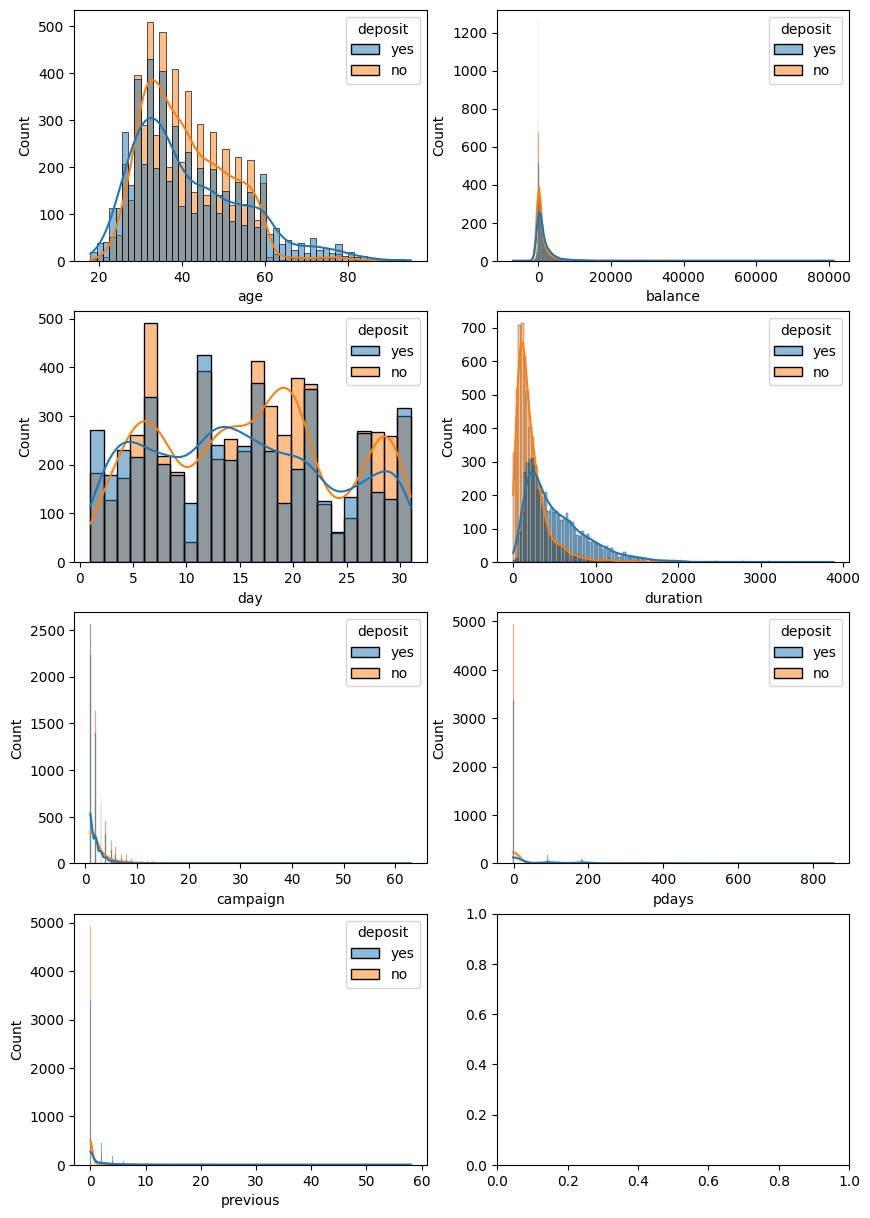

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 定義數值特徵名稱串列
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# 建立多個子圖表
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

# 繪製直方圖
for ax, name in zip(axes.flatten(), numerical_columns):
    sns.histplot(data=df_data, x=name, hue="deposit", kde=True, palette="tab10", ax=ax)

### 使用箱形圖近一步分析右偏特徵
進一步透過箱形圖進行離群值分析，協助我們更清楚地識別每個特徵的數據範圍與異常點分佈情形，以評估是否需要進行資料清理或離群值處理，藉此提升模型的準確性與穩定性。

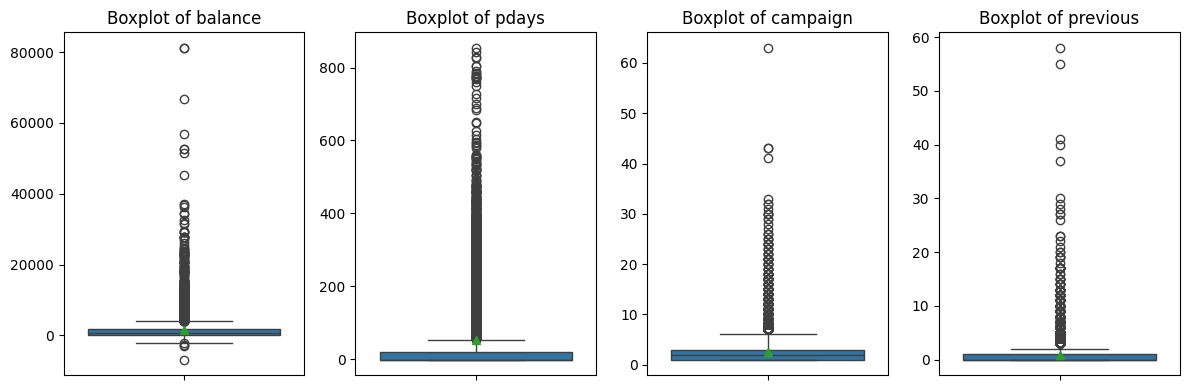

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 定義特徵名稱串列
x_feature_names = ['balance', 'pdays', 'campaign', 'previous']
# 創建一個 3x3 的子圖佈局，每個特徵將有一個獨立的子圖
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
# 將每個特徵的箱形圖分別繪製在不同的子圖中
for i, feature in enumerate(x_feature_names):
    # 使用 seaborn 繪製箱形圖
    sns.boxplot(y=df_data[feature], ax=axes[i], showmeans=True)
    axes[i].set_title(f'Boxplot of {feature}')  # 設置子圖標題
    axes[i].set_ylabel('')  # 設置 y 軸標籤為空

# 調整子圖之間的間距和布局
plt.tight_layout()
plt.show()


## 移除離群值
XGBoost 是一種 **Boosting 演算法**，它的運作方式是透過逐步修正前一次模型的錯誤來提升預測表現。因此，如果資料中存在 **離群值**（異常值），這些極端值的誤差會被反覆強調，導致模型過度專注在這些點上，進而降低整體模型的泛化能力，影響預測準確性。

- Boosting（如XGBoost）透過不斷修正前一次錯誤來訓練，因此對離群值較敏感。
- 離群值可能使模型 **過度擬合**，降低泛化能力。
- 適當處理離群值，能有效提升模型的穩定性與準確性。

In [6]:
import pandas as pd

def remove_outliers(df, numerical_columns):
    """
    根據指定的數值型欄位，移除超過3倍標準差(極端離群值)範圍的資料。

    參數：
    df (pd.DataFrame): 輸入的資料
    numerical_columns (list): 需要篩選的數值型欄位

    回傳：
    pd.DataFrame: 移除異常值後的資料
    """
    # 對於每個數值型欄位，移除超過3倍標準差範圍外的資料
    for column in numerical_columns:
        mean = df[column].mean()
        std = df[column].std()
        # 篩選出落在 [mean - 3*std, mean + 3*std] 之間的資料
        df = df[(df[column] >= (mean - 3 * std)) & (df[column] <= (mean + 3 * std))]

    return df

# 針對數值型特徵進行離群值移除
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df_data = remove_outliers(df_data, numerical_columns)


**🔍 離群值處理標準**

處理離群值時，常見的方式是透過設定倍數的標準差來篩選：

| 標準差倍數 | 說明 |
|------------|------|
| 1.5 倍     | 嚴格篩選輕微離群值，小資料集適用 |
| 2 倍       | 約 95% 的資料在此範圍內，常見的判斷標準 |
| 3 倍       | 約 99.7% 的資料在此範圍內，適合排除極端離群值 |

在此範例中，我們選擇 **3 倍標準差** 來有效避免極端離群值，降低模型過擬合的風險並提升穩定性。

---

### 直方圖分析類別型特徵分佈情形
我們將利用 `countplot()` 對資料中的類別型特徵進行視覺化，觀察這些特徵與目標變數 (`deposit`) 之間的關係。

透過將每個特徵依據是否接受定存 (`deposit`) 分組繪製，可以清楚看到不同類別下客戶的選擇比例，協助我們找出具有預測能力的特徵，並進一步優化資料處理和模型訓練。

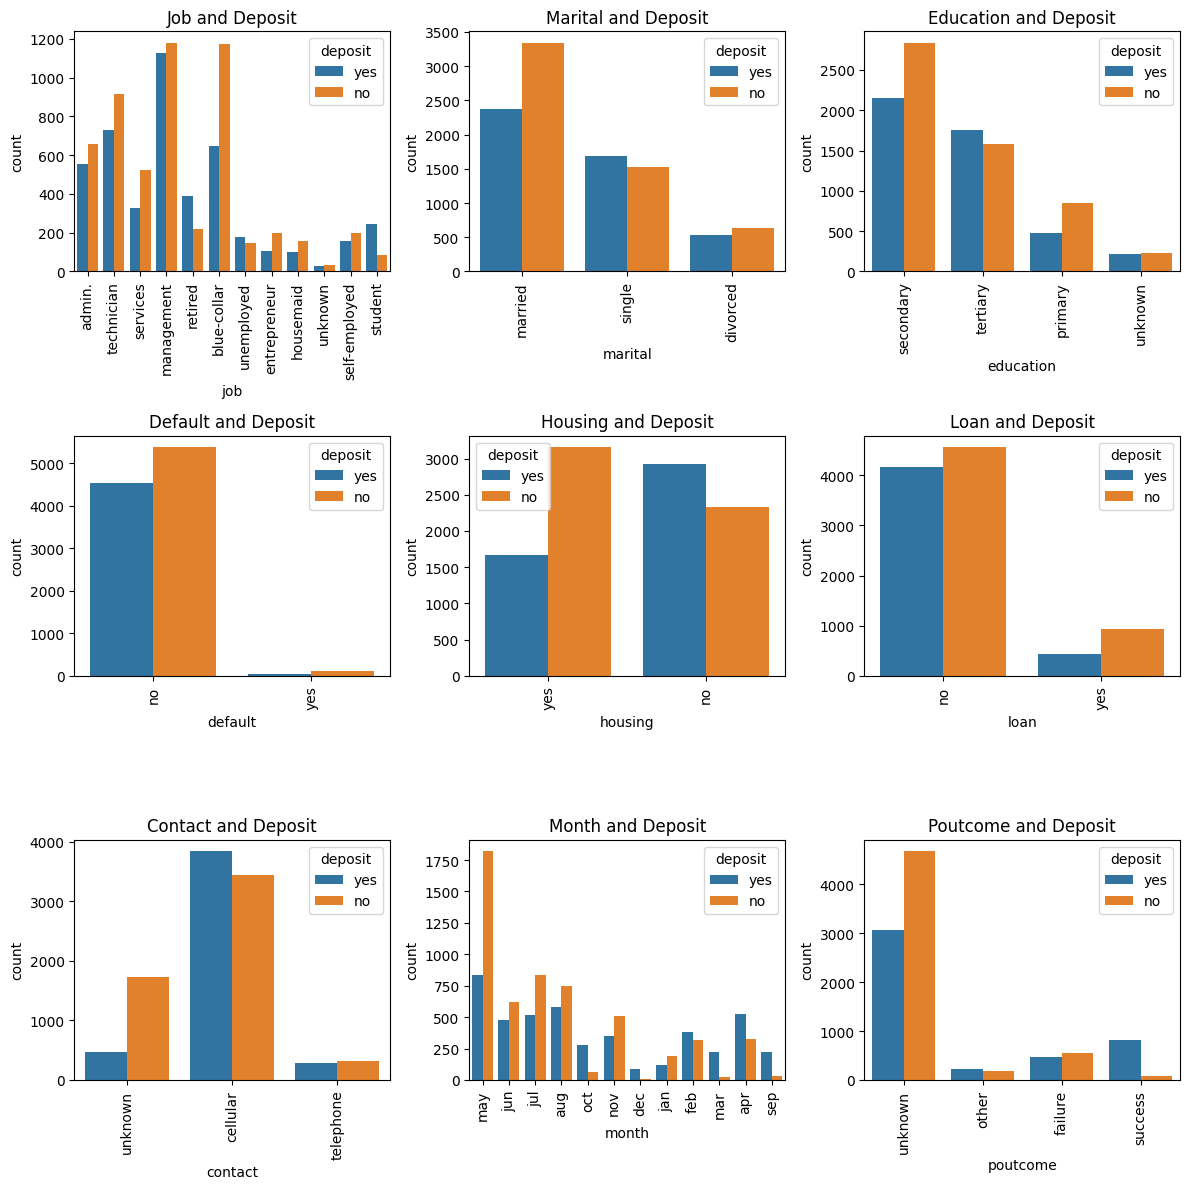

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 定義類別型特徵名稱串列
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# 建立多個子圖表
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# 繪製 countplot，對每個類別型特徵依照 deposit (yes/no) 做分組顯示
for ax, name in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=df_data, x=name, hue='deposit', palette='tab10', ax=ax)
    ax.set_title(f'{name.capitalize()} and Deposit')  # 設置子圖標題
    ax.tick_params(axis='x', rotation=90)  # 直接設定 X 軸標籤的旋轉角度

# 調整圖表之間的間距
plt.tight_layout()
plt.show()



透過類別型特徵視覺化分析，我們發現以下關鍵觀察：

| 特徵             | 主要觀察與影響               | 結論                               |
|------------------|------------------------------|------------------------------------|
| 職業 (`job`)     | 管理階層、退休者較高比例申辦定存；藍領較低 | 職業收入穩定性影響定存選擇           |
| 婚姻 (`marital`) | 單身客群申辦比例較已婚客群高 | 單身族更有餘裕投資金融產品           |
| 教育 (`education`) | 高等教育客群申辦比例較高     | 教育程度影響金融產品的接受度         |
| 違約紀錄 (`default`) | 有違約紀錄幾乎未申辦定存     | 財務狀況良好者更易接受定存           |
| 房貸 (`housing`)  | 有房貸者較少申辦定存         | 房貸支出可能限制資金投入其他金融產品 |
| 貸款 (`loan`)     | 有貸款者較少申辦定存         | 貸款負擔影響投資意願               |
| 聯絡方式 (`contact`) | 行動電話聯絡的客戶申辦比例較高 | 電話聯絡具更佳的促銷效果             |
| 月份 (`month`)    | 3、4、9月申辦比例高，5月低   | 不同月份行銷成效存在明顯差異         |
| 先前行銷結果 (`poutcome`) | 先前成功行銷的客戶申辦比例明顯較高 | 過去成功經驗顯著影響未來決策         |

**💡 結論：**  
這些觀察有助於銀行掌握不同客戶群體的金融行為模式，進一步優化行銷策略並提高定期存款產品的接受度。

---

### 目標變數 (`deposit`) 分佈視覺化

我們使用 Seaborn 的 `countplot()` 函數來觀察目標變數 `deposit` 的分佈情況。

透過直方圖，我們能直觀地看到：

- 接受定存產品 (`yes`) 的客戶數量。
- 未接受定存產品 (`no`) 的客戶數量。

圖中會標示出各類別的樣本數量，協助我們判斷資料是否存在類別不平衡的情形，並進一步評估模型對此的處理能力。









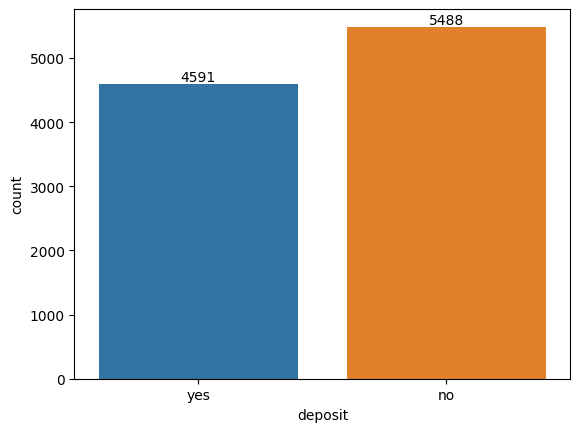

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 seaborn 的 countplot 函數繪製直方圖
ax = sns.countplot(data=df_data, x='deposit', hue='deposit', palette='tab10')
# 在每個直方圖的上方顯示 count 數值
for container in ax.containers:
    ax.bar_label(container)

## 資料清理
在訓練機器學習模型前，我們需要將資料中的 **類別型特徵**（如職業、婚姻狀況、教育程度）轉換為數值型，以便模型可以進行計算。

在這個範例中，我們使用 **Ordinal Encoding** 方法，將原本以字串呈現的特徵標籤轉換成機器能夠理解的數值型資料。

### 指定自定義的類別順序
我們首先處理資料集中具備明顯順序關係的特徵，例如：

- 教育程度 (`education`)
- 聯繫月份 (`month`)

這些特徵本身具備自然的順序，對模型訓練有重要意義。因此，我們使用 **OrdinalEncoder** 明確指定這些特徵的順序，以保留特徵之間的相對關係，進而提升模型的準確性。

In [9]:
from sklearn.preprocessing import OrdinalEncoder

# 指定自定義的類別順序
custom_categories = [
    ['primary', 'secondary', 'tertiary', 'unknown'],  # education
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']  # month
]

# 需要自定義順序的類別特徵
custom_columns = ['education', 'month']

# 對自定義的特徵進行編碼
ordinal_encoder_custom = OrdinalEncoder(categories=custom_categories)
df_data[custom_columns] = ordinal_encoder_custom.fit_transform(df_data[custom_columns])

# 顯示自定義的類別順序
for col, categories in zip(custom_columns, ordinal_encoder_custom.categories_):
    print(f'{col} 編碼順序為：{list(categories)}')

education 編碼順序為：['primary', 'secondary', 'tertiary', 'unknown']
month 編碼順序為：['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']


### 其他類別型特徵的編碼（自動推斷順序）

除了具有明確順序的特徵（如 `education` 和 `month`）外，其餘類別型特徵並不具備固定順序，我們將透過 **OrdinalEncoder 的自動推斷功能** 進行編碼。

這些特徵包含：

- 職業 (`job`)
- 婚姻狀況 (`marital`)
- 是否違約 (`default`)
- 是否有房貸 (`housing`)
- 是否有個人貸款 (`loan`)
- 聯絡方式 (`contact`)
- 先前行銷活動結果 (`poutcome`)

這樣可以將所有類別型資料轉換為模型可接受的數值型格式，便於後續的模型訓練。

In [10]:
# 自動推斷的類別特徵
auto_columns = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

# 對其他自動推斷的特徵進行編碼
ordinal_encoder_auto = OrdinalEncoder()
df_data[auto_columns] = ordinal_encoder_auto.fit_transform(df_data[auto_columns])

# 顯示自動推斷的類別順序
for col, categories in zip(auto_columns, ordinal_encoder_auto.categories_):
    print(f'{col} 編碼順序為：{list(categories)}')


job 編碼順序為：['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']
marital 編碼順序為：['divorced', 'married', 'single']
default 編碼順序為：['no', 'yes']
housing 編碼順序為：['no', 'yes']
loan 編碼順序為：['no', 'yes']
contact 編碼順序為：['cellular', 'telephone', 'unknown']
poutcome 編碼順序為：['failure', 'other', 'success', 'unknown']


## 目標變數編碼（LabelEncoder）

最後，我們需要將目標變數 `deposit` 進行數值化處理。

由於 `deposit` 是一個 **二元分類標籤**（`yes` / `no`），我們使用 **LabelEncoder** 將其轉換為數值型格式：

- `yes` → 1  
- `no`  → 0

這樣能讓機器學習模型正確識別並處理此分類任務。

In [11]:
from sklearn.preprocessing import LabelEncoder

# 建立LabelEncoder物件
label_encoder = LabelEncoder()
df_data['deposit'] = label_encoder.fit_transform(df_data['deposit'])

# 查看編碼後的順序
encoded_classes = label_encoder.classes_
print(f'deposit 編碼後的順序: {encoded_classes}')

deposit 編碼後的順序: ['no' 'yes']


In [12]:
df_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0.0,1.0,1.0,0.0,2343,1.0,0.0,2.0,5,4.0,1042,1,-1,0,3.0,1
2,41,9.0,1.0,1.0,0.0,1270,1.0,0.0,2.0,5,4.0,1389,1,-1,0,3.0,1
3,55,7.0,1.0,1.0,0.0,2476,1.0,0.0,2.0,5,4.0,579,1,-1,0,3.0,1
4,54,0.0,1.0,2.0,0.0,184,0.0,0.0,2.0,5,4.0,673,2,-1,0,3.0,1
5,42,4.0,2.0,2.0,0.0,0,1.0,1.0,2.0,5,4.0,562,2,-1,0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1.0,2.0,0.0,0.0,1,1.0,0.0,0.0,20,3.0,257,1,-1,0,3.0,0
11158,39,7.0,1.0,1.0,0.0,733,0.0,0.0,2.0,16,5.0,83,4,-1,0,3.0,0
11159,32,9.0,2.0,1.0,0.0,29,0.0,0.0,0.0,19,7.0,156,2,-1,0,3.0,0
11160,43,9.0,1.0,1.0,0.0,0,0.0,1.0,0.0,8,4.0,9,2,172,5,0.0,0


## 切割訓練集與測試集
我們先定義一組輸入特徵 `x_feature_names`，包含客戶的年齡、職業、婚姻狀況、教育程度、貸款狀況等，共 16 個欄位。

- `X`：輸入特徵資料（共 16 欄）
- `y`：目標變數 `deposit`

接著，使用 `train_test_split()` 將資料切分為 **訓練集** 與 **測試集**，其中：

- 測試集佔比設為 **10%**
- 使用 `stratify=y` 參數，確保分割後的資料中，目標變數的分佈仍與原始資料一致，避免樣本不均問題影響模型訓練。









In [13]:
from sklearn.model_selection import train_test_split

# 定義特徵名稱串列
x_feature_names = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome']
# 根據指定欄位取得輸入特徵
X = df_data[x_feature_names].values
# 目標輸出
y = df_data['deposit'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Shape of training set X:', X_train.shape)
print('Shape of testing set X:', X_test.shape)

Shape of training set X: (8063, 16)
Shape of testing set X: (2016, 16)


## 建立XGBoost分類模型
Boosting 則是希望能夠由後面生成的樹，來修正前面樹學的不好的地方。

參數 (Parameters):
- n_estimators：決定迭代的總次數，即模型中決策樹的數量，預設值為 100。
- max_depth：樹的最大深度，預設值為 6，控制樹的複雜度。
- booster：選擇模型的類型，可以是樹模型 gbtree（預設）或線性模型 gbliner。
- learning_rate：學習速率，控制每次更新的步幅，預設值為 0.3。
- gamma：節點分裂的最小損失函數下降值，這個懲罰項有助於防止過度分裂。

屬性 (Attributes):
- feature_importances_: 查詢模型特徵的重要程度。

方法 (Methods):
- fit(X, y): 將特徵資料 X 和目標變數 y 放入進行模型擬合。
- predict(X): 進行預測並返回預測類別。
- score(X, y): 計算預測成功的比例。
- predict_proba(X): 返回每個類別的預測機率值。

In [14]:
from xgboost import XGBClassifier

# 建立 XGBClassifier 模型
xgb_clf = XGBClassifier(n_estimators=20, learning_rate= 0.3)
# 使用訓練資料訓練模型
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 評估模型
模型訓練完成後，我們會評估其在 **訓練集** 和 **測試集** 上的表現，主要觀察準確度（accuracy）是否穩定。

- 若訓練集準確度遠高於測試集，可能出現 **過擬合**，代表模型只記住了訓練資料，無法有效泛化。
- 若訓練與測試集準確度相近且表現良好，則模型具備良好的預測能力。

透過這些指標，我們能判斷模型是否需要進行 **超參數調整**（例如 `n_estimators` 或 `max_depth`），以改善過擬合或提升效能。

In [15]:
train_accuracy = xgb_clf.score(X_train, y_train)
test_accuracy = xgb_clf.score(X_test, y_test)

print('訓練集準確度: ', train_accuracy)
print('測試集準確度: ', test_accuracy)

訓練集準確度:  0.8958204142378767
測試集準確度:  0.8685515873015873


### 更細緻的分類評估指標（classification_report）

除了整體準確度（accuracy），我們也使用 `classification_report` 來評估模型在分類任務中的細節表現。

此報告會根據 `y_test`（實際值）與 `y_pred`（模型預測值）產生以下指標：

- **精確度（Precision）**：預測為正確類別的比例  
- **召回率（Recall）**：實際為正類別中被正確預測的比例  
- **F1-score**：精確度與召回率的加權平均  

這些指標能夠幫助我們更細緻地判斷模型在各類別上的表現，特別適用於處理 **類別不平衡** 的問題。

In [16]:
from sklearn.metrics import classification_report

# 模型預測
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1098
           1       0.83      0.89      0.86       918

    accuracy                           0.87      2016
   macro avg       0.87      0.87      0.87      2016
weighted avg       0.87      0.87      0.87      2016



從 `classification_report` 的結果來看：

- 預測「**不申辦定存**」的 **精確度（precision）** 較高，達 **0.90**。
- 預測「**申辦定存**」的 **召回率（recall）** 表現良好，達 **0.89**，代表模型能成功找出大多數有意願定存的客戶。
- 兩類的 **F1-score** 分別為 **0.88** 和 **0.86**，整體平衡不錯。
- **總體準確度為 87%**，表示模型在測試資料上的預測能力相當穩定且具實用價值。


#### Precision vs. Recall 有什麼不同？何時該用？

**Precision（精確度）**

- 定義：在所有**被預測為正類別**的樣本中，有多少是真的。
- 重點：**降低誤判（False Positive）**。
- 適用時機：當錯誤預測為「正類」的代價很高時。
  - 例：垃圾郵件分類（別誤殺正常信件）

**Recall（召回率）**

- 定義：在所有**實際為正類別**的樣本中，有多少被正確預測出來。
- 重點：**降低漏判（False Negative）**。
- 適用時機：當錯過正類會造成嚴重後果時。
  - 例：癌症篩檢（不要漏掉有病的病人）

> 想同時兼顧 precision 與 recall，可以看綜合指標 **F1-score**

## 模型的可解釋性
在完成模型訓練後，了解 **哪些特徵對預測最有貢獻** 有助於我們理解模型。

XGBoost 提供 `feature_importances_` 屬性，可取得每個特徵的重要性得分。我們可以將這些數值透過 **水平長條圖** 進行視覺化，並依照貢獻度排序。

**為什麼要看特徵重要性？**

- 幫助我們了解模型「看重」哪些資料欄位
- 有助於未來資料欄位的簡化或優化
- 可作為業務決策與策略調整的參考依據

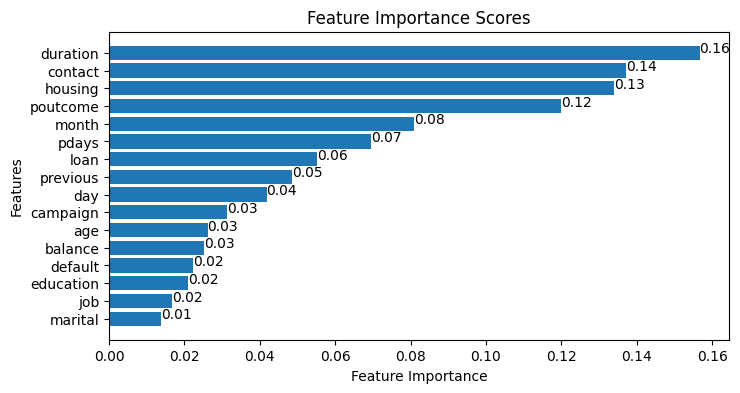

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 提取特徵重要性數值
importances = xgb_clf.feature_importances_
# 取得特徵重要性排序後的索引
indices = np.argsort(importances)

# 繪製水平長條圖
plt.figure(figsize=(8, 4))
bar_plot = plt.barh(range(len(x_feature_names)), importances[indices], align='center')
plt.yticks(range(len(x_feature_names)), [x_feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
# 在每個bar後面顯示數值
for rect in bar_plot:
    width = rect.get_width()
    plt.annotate(f'{width:.2f}', xy=(width, rect.get_y() + rect.get_height() / 2))
plt.show()


透過特徵重要性圖，我們可以了解哪些特徵對預測「是否申辦定存」影響最大。以下是主要觀察重點：

| 特徵名稱 (`feature`)     | 分析與觀察結論 |
|--------------------------|----------------|
| 通話時長 (`duration`)     | 最具影響力的特徵，通話時間越長，客戶越可能接受定存產品。 |
| 聯絡方式 (`contact`)     | 不同聯繫方式影響顧客決策，顯示出聯絡管道的溝通效果很關鍵。 |
| 是否有房貸 (`housing`)    | 有無房貸與是否願意定存具明顯關聯，可能反映其資金運用空間。 |
| 上次行銷結果 (`poutcome`)| 先前行銷是否成功會影響客戶這次的回應意願。 |

這些結果有助於我們在實務應用中針對不同客戶特徵制定更有效的行銷策略。

---

## Reference
- [Kaggle](https://www.kaggle.com/code/aleksandradeis/bank-marketing-analysis)